In [1]:
import pandas as pd
import numpy as np
from convlstm import ConvLSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import os
from skimage import io

data_train = pd.read_csv("dataset/data_skill_corner/label_edit.txt",skiprows=1,
                         names=['frame','intention_type','current_velocity','steering_wheel_angle','dlm'],
                         sep='\s+')
data_train = data_train.to_numpy()
y_train = data_train
#print (y_train.shape)

In [2]:
class RGBDataset():
    """Face Landmarks dataset."""
        
    def __init__(self, nb_frames,root_dir):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_train = pd.read_csv("dataset/data_skill_corner/label_edit.txt",skiprows=1,
                                       names=['frame','intention_type','current_velocity',
                                              'steering_wheel_angle','dlm'],sep='\s+').to_numpy()
        
        self.nb_frames = nb_frames
        self.root_dir = root_dir


    def __len__(self):
        #return len(self.data_train) - self.nb_frames
        return 15000
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        X_train_t = [io.imread(os.path.join(self.root_dir,str(self.data_train[idx+i,0])+'.jpg')).astype(np.float32) for i in range (self.nb_frames)] 
        X_train = np.stack(X_train_t, axis=0)        
        X_train1 = np.moveaxis(X_train,-1,1)
        
        y_train = self.data_train[idx+self.nb_frames,2:4].astype(np.float32)
        y_train1 = y_train.reshape(1,2)
        sample = {'X_train': X_train1, 'y_train': y_train1}

        return sample

In [71]:
NUM_FRAMES=5

rgb_dataset = RGBDataset(NUM_FRAMES,'dataset/data_skill_corner/rgb_0/') #frame
sample = rgb_dataset[0]
print (sample['X_train'].shape)
print (sample['y_train'].shape)
from torch.utils.data import Dataset, DataLoader
dataloader = DataLoader(rgb_dataset, batch_size=8,
                        shuffle=False, num_workers=2)

(5, 3, 224, 224)
(1, 2)


In [72]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        global NUM_FRAMES
        #self.conv1 = ConvLSTM(input_channels=1, hidden_channels=[64, 32, 32], kernel_size=3, step=5,
        #           effective_step=[4]).cuda()
        
        self.maxpool= nn.MaxPool3d((1,5,5),stride=(1,3,3))
        self.BD = nn.BatchNorm2d(16)
        self.drop = nn.Dropout(p=0.3)
        self.conv1 = ConvLSTM(input_size = (74,74), input_dim = 3, hidden_dim = [32, 16, 16], 
                              kernel_size = (3,3), num_layers = 3, batch_first=True)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3,stride=2)
        self.fc1 = nn.Linear(NUM_FRAMES*16*9*9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        
        x = self.maxpool(x)
        #print (x.shape)
        x = self.conv1(x)     
        x = self.BD(x[0][0])    
        x = F.relu(F.max_pool2d(x,2))  
        #x = self.drop(x)
        x = self.BD(self.conv2(x))  
        x = F.relu(F.max_pool2d(x,2))  
        
        x = x.view(1,-1)        
        x = F.relu(self.fc1(x))       
        x = F.relu(self.fc2(x))
        #x = self.drop(x)
        x = self.fc3(x).reshape(-1,1,2)
        return x


net = Net().cuda()

print(net)

print(sum(p.numel() for p in net.parameters()))

Net(
  (maxpool): MaxPool3d(kernel_size=(1, 5, 5), stride=(1, 3, 3), padding=0, dilation=1, ceil_mode=False)
  (BD): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.3, inplace=False)
  (conv1): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(35, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): ConvLSTMCell(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=6480, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)
877062


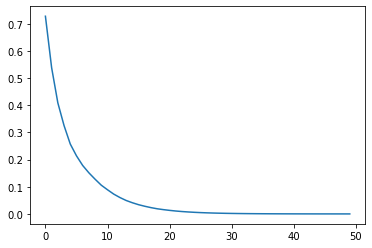

In [73]:
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.autograd import Variable
net1 = Net().cuda()
p = Variable(torch.randn(1,5, 3, 224, 224)).cuda()
q = Variable(torch.randn(1,1,2)).cuda()
#print (out.shape)

criterion = nn.MSELoss()
optimizer = optim.SGD(net1.parameters(), lr=0.001)
#optimizer = optim.Adam(net.parameters(), lr=0.01,betas=(0.9,0.99))
loss_values = []
for i in range (50):
    optimizer.zero_grad()
     
    out = net1(p)

    los = criterion(out, q)
      
    los.backward()
    #print(i,los)
    optimizer.step()
    
    loss_values.append(los.item())
#del p,q,out,los
#torch.cuda.empty_cache()     
plt.plot(loss_values)     

In [74]:
del net,X_t,y_t,outputs,loss
torch.cuda.empty_cache()   

NameError: name 'X_t' is not defined

[1,   100] loss: 0.622
[1,   200] loss: 0.443
[1,   300] loss: 0.281
[1,   400] loss: 0.293
[1,   500] loss: 0.214
[1,   600] loss: 0.193
[1,   700] loss: 0.271
[1,   800] loss: 0.199
[1,   900] loss: 0.174
[1,  1000] loss: 0.158
[1,  1100] loss: 0.115
[1,  1200] loss: 0.326
[1,  1300] loss: 0.178
[1,  1400] loss: 0.096
[1,  1500] loss: 0.175
[1,  1600] loss: 0.320
[1,  1700] loss: 0.108
[1,  1800] loss: 0.143
0 14.389663186389953
[2,   100] loss: 0.081
[2,   200] loss: 0.321
[2,   300] loss: 0.128
[2,   400] loss: 0.241
[2,   500] loss: 0.161
[2,   600] loss: 0.116
[2,   700] loss: 0.242
[2,   800] loss: 0.132
[2,   900] loss: 0.155
[2,  1000] loss: 0.119
[2,  1100] loss: 0.071
[2,  1200] loss: 0.284
[2,  1300] loss: 0.136
[2,  1400] loss: 0.075
[2,  1500] loss: 0.148
[2,  1600] loss: 0.301
[2,  1700] loss: 0.079
[2,  1800] loss: 0.117
1 13.861641759052873
[3,   100] loss: 0.062
[3,   200] loss: 0.301
[3,   300] loss: 0.105
[3,   400] loss: 0.234
[3,   500] loss: 0.150
[3,   600] loss

[19,  1000] loss: 0.065
[19,  1100] loss: 0.045
[19,  1200] loss: 0.165
[19,  1300] loss: 0.069
[19,  1400] loss: 0.043
[19,  1500] loss: 0.080
[19,  1600] loss: 0.172
[19,  1700] loss: 0.044
[19,  1800] loss: 0.073
18 8.41302842926234
[20,   100] loss: 0.044
[20,   200] loss: 0.184
[20,   300] loss: 0.057
[20,   400] loss: 0.135
[20,   500] loss: 0.082
[20,   600] loss: 0.057
[20,   700] loss: 0.140
[20,   800] loss: 0.080
[20,   900] loss: 0.095
[20,  1000] loss: 0.064
[20,  1100] loss: 0.045
[20,  1200] loss: 0.161
[20,  1300] loss: 0.067
[20,  1400] loss: 0.042
[20,  1500] loss: 0.079
[20,  1600] loss: 0.168
[20,  1700] loss: 0.043
[20,  1800] loss: 0.072
19 8.173784857615829
[21,   100] loss: 0.044
[21,   200] loss: 0.180
[21,   300] loss: 0.057
[21,   400] loss: 0.131
[21,   500] loss: 0.079
[21,   600] loss: 0.057
[21,   700] loss: 0.135
[21,   800] loss: 0.079
[21,   900] loss: 0.093
[21,  1000] loss: 0.062
[21,  1100] loss: 0.044
[21,  1200] loss: 0.156
[21,  1300] loss: 0.066

[37,  1200] loss: 0.109
[37,  1300] loss: 0.048
[37,  1400] loss: 0.032
[37,  1500] loss: 0.054
[37,  1600] loss: 0.106
[37,  1700] loss: 0.038
[37,  1800] loss: 0.063
36 5.325211917981505
[38,   100] loss: 0.040
[38,   200] loss: 0.133
[38,   300] loss: 0.043
[38,   400] loss: 0.085
[38,   500] loss: 0.055
[38,   600] loss: 0.043
[38,   700] loss: 0.085
[38,   800] loss: 0.066
[38,   900] loss: 0.066
[38,  1000] loss: 0.042
[38,  1100] loss: 0.042
[38,  1200] loss: 0.107
[38,  1300] loss: 0.047
[38,  1400] loss: 0.032
[38,  1500] loss: 0.053
[38,  1600] loss: 0.103
[38,  1700] loss: 0.038
[38,  1800] loss: 0.062
37 5.233279428444803
[39,   100] loss: 0.040
[39,   200] loss: 0.131
[39,   300] loss: 0.043
[39,   400] loss: 0.084
[39,   500] loss: 0.054
[39,   600] loss: 0.044
[39,   700] loss: 0.083
[39,   800] loss: 0.065
[39,   900] loss: 0.065
[39,  1000] loss: 0.041
[39,  1100] loss: 0.042
[39,  1200] loss: 0.105
[39,  1300] loss: 0.046
[39,  1400] loss: 0.032
[39,  1500] loss: 0.05

[55,  1400] loss: 0.028
[55,  1500] loss: 0.042
[55,  1600] loss: 0.075
[55,  1700] loss: 0.036
[55,  1800] loss: 0.057
54 3.9946824917569757
[56,   100] loss: 0.035
[56,   200] loss: 0.104
[56,   300] loss: 0.038
[56,   400] loss: 0.064
[56,   500] loss: 0.046
[56,   600] loss: 0.036
[56,   700] loss: 0.062
[56,   800] loss: 0.054
[56,   900] loss: 0.052
[56,  1000] loss: 0.034
[56,  1100] loss: 0.037
[56,  1200] loss: 0.080
[56,  1300] loss: 0.038
[56,  1400] loss: 0.028
[56,  1500] loss: 0.041
[56,  1600] loss: 0.074
[56,  1700] loss: 0.036
[56,  1800] loss: 0.055
55 3.893197364639491
[57,   100] loss: 0.035
[57,   200] loss: 0.103
[57,   300] loss: 0.038
[57,   400] loss: 0.064
[57,   500] loss: 0.046
[57,   600] loss: 0.035
[57,   700] loss: 0.061
[57,   800] loss: 0.054
[57,   900] loss: 0.052
[57,  1000] loss: 0.034
[57,  1100] loss: 0.037
[57,  1200] loss: 0.079
[57,  1300] loss: 0.038
[57,  1400] loss: 0.027
[57,  1500] loss: 0.041
[57,  1600] loss: 0.073
[57,  1700] loss: 0.0

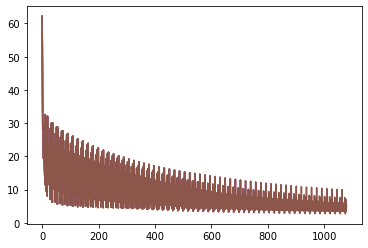

In [75]:
import torch.optim as optim
import matplotlib.pyplot as plt
# create your optimizer
net = Net().cuda()
criterion = nn.MSELoss()
#optimizer = optim.Adam(net.parameters(), lr=0.005,betas=(0.9,0.99))
optimizer = optim.SGD(net.parameters(), lr=0.00001)
loss_values = []
for epoch in range(60):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(dataloader,0):
        # get the inputs; data is a list of [inputs, labels]
        X_t, y_t = data['X_train'].cuda(),data['y_train'].cuda()
        
        #print(X_t) #torch.Size([10, 5, 3, 224, 224]) torch.Size([10, 1, 2])
        # zero the parameter gradients
        optimizer.zero_grad()
        
        
        for j in range (len(X_t)):
            outputs = net(X_t[j].reshape(1,NUM_FRAMES,3,224,224))
            if j == 0:
                loss = criterion(outputs, y_t[j].reshape(1,1,2))
                #print(loss)
                
            else:
                loss += criterion(outputs, y_t[j].reshape(1,1,2))
                #print(loss)
            #print(i,loss,len(X_t))
        #print(j,loss)
        #outputs = net(X_t.reshape(1,NUM_FRAMES,3,224,224))
        #loss = criterion(outputs, y_t.reshape(1,1,2))
           
        loss.backward()
        optimizer.step()
        

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
            
            loss_values.append(running_loss)    
            running_loss = 0
        
        
    print(epoch,running_loss)        
    if epoch%10==9:
        plt.plot(loss_values) 

   


print('Finished Training')


(1080,)


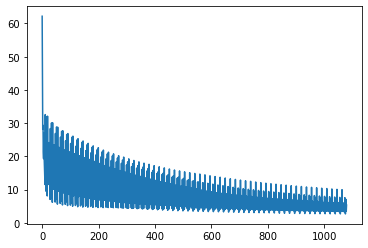

In [91]:
torch.save(net.state_dict(), 'dataset/data_skill_corner/model_002')

In [ ]:
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval() 